Preprocessing of the [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). Rational for some steps comes from [dataset exploration](https://github.com/katarinagresova/MLprojects/blob/main/BookRecommendations/playground.ipynb) notebok.

# Notes

- it could be interesting to add feature *language* to books - there are many different languages in dataset

# Setup

In [1]:
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

--2021-11-08 17:33:27--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)|132.230.105.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘BX-CSV-Dump.zip’

BX-CSV-Dump.zip     100%[===================>]  24.88M  11.5MB/s    in 2.2s    

2021-11-08 17:33:30 (11.5 MB/s) - ‘BX-CSV-Dump.zip’ saved [26085508/26085508]



In [2]:
!unzip BX-CSV-Dump.zip

Archive:  BX-CSV-Dump.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
!pip install isbnlib

     |████████████████████████████████| 65 kB 2.6 MB/s 


In [4]:
import pandas as pd
import isbnlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [24]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding = "ISO-8859-1")
books = pd.read_csv('BX-Books.csv', sep=';', encoding = "ISO-8859-1", escapechar = "\\")
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = "ISO-8859-1")

# Books table

## Data completing

### Missing books records

In [25]:
ratings['ISBN'][~ratings['ISBN'].isin(books['ISBN'])]

6           3257224281
7           0600570967
9            342310538
25          3442437407
26          033390804X
              ...     
1149444     0747252327
1149446     8804413530
1149581     0679781587
1149758     8445072897
1149779    05162443314
Name: ISBN, Length: 118605, dtype: object

We have ratings for 118 605 books that are not in *books* dataset. I created following function for looking up book metadata via `isbnlib` package. But it is not supporting batch request so it would take more then 30h to run.

In [26]:
def find_lost_books():

  new_books = []
  not_found = []
  for missing_isbn in tqdm(ratings['ISBN'][~ratings['ISBN'].isin(books['ISBN'])]):

    try:
      book = isbnlib.meta(missing_isbn, service='goob')
    except:
      try: 
        book = isbnlib.meta(missing_isbn, service='wiki')
      except:
        not_found.append(missing_isbn)
        continue

    if not book:
      not_found.append(missing_isbn)
      continue
    isbn_id = 'ISBN-13' if 'ISBN-13' in book.keys() else 'ISBN-10'
    new_books.append([
        book[isbn_id],
        book['Title'],
        book['Authors'][0],
        book['Year'],
        book['Publisher']
    ])
    
  return new_books, not_found

In [27]:
# do this if you have more then 30 hours
#new_books, not_found = find_lost_books()
#books.append(pd.DataFrame(new_books, columns=books.columns))
#print(not_found)

In [28]:
books_count = len(books)
ratings_count = len(ratings)
unique_books = len(books['ISBN'].unique())
unique_ratings = len(ratings['ISBN'].unique())

print("Books count: ", books_count)
print("Books count in ratings: ", ratings_count)
print("Unique books count: ", unique_books)
print("Unique books in ratings: ", unique_ratings)

Books count:  271379
Books count in ratings:  1149780
Unique books count:  271379
Unique books in ratings:  340556


In [29]:
# for now, just drop rating without record in books
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings = ratings.reset_index(drop=True)

In [30]:
print("Removed books: ", books_count - len(books))
print("Removed books in ratings: ", ratings_count - len(ratings))
print("Removed unique books: ", unique_books - len(books['ISBN'].unique()))
print("Removed unique books in ratings: ", unique_ratings - len(ratings['ISBN'].unique()))

books_count = len(books)
ratings_count = len(ratings)
unique_books = len(books['ISBN'].unique())
unique_ratings = len(ratings['ISBN'].unique())

Removed books:  0
Removed books in ratings:  118605
Removed unique books:  0
Removed unique books in ratings:  70386


### Missing book metadata

In [31]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


There is one record with missing author, so we might try to look it up by hand.

In [32]:
books[books['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [33]:
isbnlib.meta('9627982032', service='wiki')

{'Authors': ['Larissa Downes', 'Crédit suisse'],
 'ISBN-13': '9789627982036',
 'Language': '',
 'Publisher': 'Edinburgh Financial Pub. (Asia)',
 'Title': 'The Credit Suisse guide to managing your personal wealth',
 'Year': '1995'}

In [34]:
books.at[187700, 'Book-Author'] = 'Larissa Downes'

In [35]:
books[books['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [36]:
books.describe()

,Year-Of-Publication
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [37]:
books[books['Year-Of-Publication'].apply(lambda x: x < 1900 or x > 2010)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH",http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV),http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...
...,...,...,...,...,...,...,...,...
270813,014029953X,Foe (Essential.penguin S.),J.M. Coetzee,0,Penguin Books Ltd,http://images.amazon.com/images/P/014029953X.0...,http://images.amazon.com/images/P/014029953X.0...,http://images.amazon.com/images/P/014029953X.0...
270932,0340571187,Postmens House,Maggie Hemingway,0,Trafalgar Square,http://images.amazon.com/images/P/0340571187.0...,http://images.amazon.com/images/P/0340571187.0...,http://images.amazon.com/images/P/0340571187.0...
271113,8427201079,El Misterio De Sittaford,Agatha Christie,0,Editorial Molino,http://images.amazon.com/images/P/8427201079.0...,http://images.amazon.com/images/P/8427201079.0...,http://images.amazon.com/images/P/8427201079.0...
271201,0887781721,Tom Penny,Tony German,0,P. Martin Associates,http://images.amazon.com/images/P/0887781721.0...,http://images.amazon.com/images/P/0887781721.0...,http://images.amazon.com/images/P/0887781721.0...


With bit of time we might try to lookup years of publication.

In [38]:
def find_lost_years():

  not_found = []
  for index in tqdm(books[books['Year-Of-Publication'].apply(lambda x: x < 1900 or x > 2010)].index):

    try:
      book = isbnlib.meta(books['ISBN'][index], service='goob')
    except:
      continue

    if not book:
      not_found.append(index)
      continue

    if 'Year' in books.keys():
      books['Year-Of-Publication'][index] = book['Year']
    else:
      not_found.append(index)
    
  return not_found

In [39]:
#not_found = find_lost_years()
#print(not_found)

## Data cleaning

Data cleaning on `books` table is connected to `ratings` table, because ISBN is used as primary key,

### Useless columns

Let's look at columns if there are some useful information.

In [40]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


We might use image in final application to show a preview of sugested books to a user. Or we could use it in multi-modal model as one of input for computing similarity between books. But for now, we will not need it, since we will do just simple proof-of-concept recommendation system.

In [41]:
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

In [42]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### Transforming ISBN to cannonical form

I found this nice python package called [isbnlib](https://github.com/xlcnd/isbnlib) that can be used to validate, clean, transform, hyphenate and get metadata for ISBN strings.

Reasons for bothering with ISBN numbers:
- transform ISBN numbers into standard form to prevent duplicate entries
- use ISBN as unique and valid identificator of a book, so we could connect it with other resources where books are identified by ISBN number.


In [43]:
books['ISBN'] = books['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x)))
ratings['ISBN'] = ratings['ISBN'].apply(lambda x: isbnlib.canonical(isbnlib.clean(x)))

In [44]:
print("Removed books: ", books_count - len(books))
print("Removed books in ratings: ", ratings_count - len(ratings))
print("Removed unique books: ", unique_books - len(books['ISBN'].unique()))
print("Removed unique books in ratings: ", unique_ratings - len(ratings['ISBN'].unique()))

books_count = len(books)
ratings_count = len(ratings)
unique_books = len(books['ISBN'].unique())
unique_ratings = len(ratings['ISBN'].unique())

Removed books:  0
Removed books in ratings:  0
Removed unique books:  431
Removed unique books in ratings:  424


As we can see, after trasforming to cannonical form, we have less unique ISBN numbers.

### Removing invalid ISBN

In [45]:
invalid_ISBN = {
                *set(books['ISBN'][books['ISBN'].apply(lambda x: (not isbnlib.is_isbn10(x)) and (not isbnlib.is_isbn13(x)))]),
                *set(ratings['ISBN'][ratings['ISBN'].apply(lambda x: (not isbnlib.is_isbn10(x)) and (not isbnlib.is_isbn13(x)))])
}
print(len(invalid_ISBN))
print(list(invalid_ISBN)[:10])

1
['']


Empty ISBN is result of trying to transform ASIN (Amazon ID) to correct ISBN numbers. There we few ASIN numbers in original data and there is no straightforward way how to transform them to ISBN (except for mining Amazon websites).

Some of invalid ISBN could be manualy fixed - there are typos.


In [46]:
books['ISBN'].apply(lambda x: x in invalid_ISBN).value_counts()

False    271262
True        117
Name: ISBN, dtype: int64

In [47]:
books = books[books['ISBN'].apply(lambda x: x not in invalid_ISBN)]
ratings = ratings[ratings['ISBN'].apply(lambda x: x not in invalid_ISBN)]

In [48]:
print("Removed books: ", books_count - len(books))
print("Removed books in ratings: ", ratings_count - len(ratings))
print("Removed unique books: ", unique_books - len(books['ISBN'].unique()))
print("Removed unique books in ratings: ", unique_ratings - len(ratings['ISBN'].unique()))

books_count = len(books)
ratings_count = len(ratings)
unique_books = len(books['ISBN'].unique())
unique_ratings = len(ratings['ISBN'].unique())

Removed books:  117
Removed books in ratings:  165
Removed unique books:  1
Removed unique books in ratings:  1


### Deduplicating ISBN

- for books: drop duplicates
- for ratings: duplicates have been merged by transforming to cannonical forms

In [49]:
books = books.drop_duplicates(subset='ISBN')

In [50]:
print("Removed books: ", books_count - len(books))
print("Removed books in ratings: ", ratings_count - len(ratings))
print("Removed unique books: ", unique_books - len(books['ISBN'].unique()))
print("Removed unique books in ratings: ", unique_ratings - len(ratings['ISBN'].unique()))

books_count = len(books)
ratings_count = len(ratings)
unique_books = len(books['ISBN'].unique())
unique_ratings = len(ratings['ISBN'].unique())

Removed books:  315
Removed books in ratings:  0
Removed unique books:  0
Removed unique books in ratings:  0


### Lowercase title and author

In [52]:
books['Book-Author'] = books['Book-Author'].apply(
    lambda x: x.lower(),
)
books['Book-Title'] = books['Book-Title'].apply(
    lambda x: x.lower(),
)

In [53]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,classical mythology,mark p. o. morford,2002,Oxford University Press
1,0002005018,clara callan,richard bruce wright,2001,HarperFlamingo Canada
2,0060973129,decision in normandy,carlo d'este,1991,HarperPerennial
3,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999,Farrar Straus Giroux
4,0393045218,the mummies of urumchi,e. j. w. barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271374,0440400988,there's a bat in bunk five,paula danziger,1988,Random House Childrens Pub (Mm)
271375,0525447644,from one to one hundred,teri sloat,1991,Dutton Books
271376,006008667X,lily dale : the true story of the town that ta...,christine wicker,2004,HarperSanFrancisco
271377,0192126040,republic (world's classics),plato,1996,Oxford University Press


# Users table

When we look at users metadata, they are sparse and misleading. And we are not able to easily correct them (we might manualy correct some locations). So we will rather not use them.

In [54]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [55]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [56]:
users['Location'].apply(lambda x: x.split(',')[-1].strip('\"')).value_counts()

 usa               139712
 canada             21658
 united kingdom     18556
 germany            17073
 spain              13258
                    ...  
 carter                 1
 livingston             1
 fifi                   1
 23232                  1
 myanmar                1
Name: Location, Length: 631, dtype: int64

In [57]:
users = users.drop(columns=['Location', 'Age'])
users

,User-ID
0,1
1,2
2,3
3,4
4,5
...,...
278853,278854
278854,278855
278855,278856
278856,278857


# Ratings table

In [58]:
def plot_groupby_stats(ratings):

  avg_user_rating = ratings.groupby('User-ID')["Book-Rating"].mean()
  num_ratings_by_user = ratings.groupby('User-ID')["Book-Rating"].count()
  avg_book_rating = ratings.groupby('ISBN')["Book-Rating"].mean()
  num_ratings_by_book = ratings.groupby('ISBN')["Book-Rating"].count()

  n_rows = 2
  n_cols = 2
  fig=plt.figure(figsize=(10, 10))

  ax = fig.add_subplot(n_rows, n_cols, 1)
  avg_user_rating.plot.box(ax=ax)
  ax.set_title("Average user rating")

  ax = fig.add_subplot(n_rows, n_cols, 2)
  num_ratings_by_user.plot.box(ax=ax)
  ax.set_title("Number of ratings by user")

  ax = fig.add_subplot(n_rows, n_cols, 3)
  avg_book_rating.plot.box(ax=ax)
  ax.set_title("Average book rating")

  ax = fig.add_subplot(n_rows, n_cols, 4)
  num_ratings_by_book.plot.box(ax=ax)
  ax.set_title("Number of ratings by book")

  fig.tight_layout()  # Improves appearance a bit.
  plt.show()

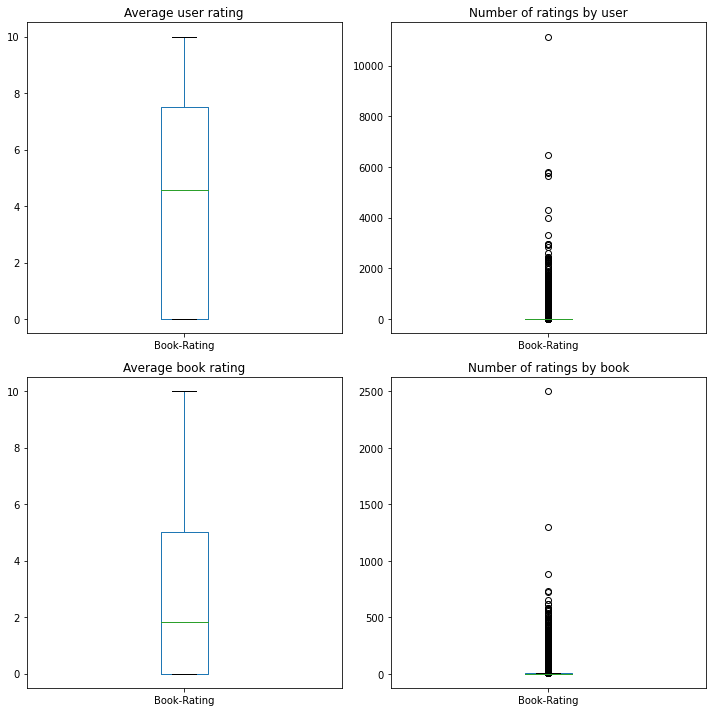

In [59]:
plot_groupby_stats(ratings)

## Drop weakly rated books

I decided to keep all books during preprocessing. Droping weakly rated books can be done differently for different recommendations algorithms.

In [60]:
#num_ratings_by_book = ratings.groupby('ISBN')["Book-Rating"].count()
#ratings['Book-Rating'][ratings['ISBN'].isin(num_ratings_by_book[num_ratings_by_book < 100].index)].value_counts()

In [61]:
#ratings = ratings[ratings['ISBN'].isin(num_ratings_by_book[num_ratings_by_book > 99].index)]
#ratings = ratings.reset_index(drop=True)

In [62]:
#plot_groupby_stats(ratings)

## Normalize ratings

Mean normalization
- take average rating of an item and subtract that average from every rating of that item
- the same for users - take an average user's rating and subtract it from all ratings that user gave

In [63]:
avg_book_rating = ratings.groupby('ISBN')["Book-Rating"].mean()
avg_book_rating

ISBN
0000913154    8.0
0001010565    0.0
0001046438    9.0
0001046713    0.0
000104687X    6.0
             ... 
9999669972    0.0
9999980538    3.0
9999984584    0.0
9999991556    0.0
9999999999    5.0
Name: Book-Rating, Length: 269745, dtype: float64

In [64]:
ratings['Book-Rating'] = ratings.apply(
    lambda x: x['Book-Rating'] - avg_book_rating[x['ISBN']],
    axis=1
)

In [65]:
avg_user_rating = ratings.groupby('User-ID')["Book-Rating"].mean()
avg_user_rating

User-ID
2         0.000000
8        -0.777750
9        -2.060210
10       -2.000000
12        6.666667
            ...   
278846    4.125000
278849    1.433333
278851    0.220735
278852    4.076923
278854    3.189461
Name: Book-Rating, Length: 92100, dtype: float64

In [66]:
ratings['Book-Rating'] = ratings.apply(
    lambda x: x['Book-Rating'] - avg_user_rating[x['User-ID']],
    axis=1
)

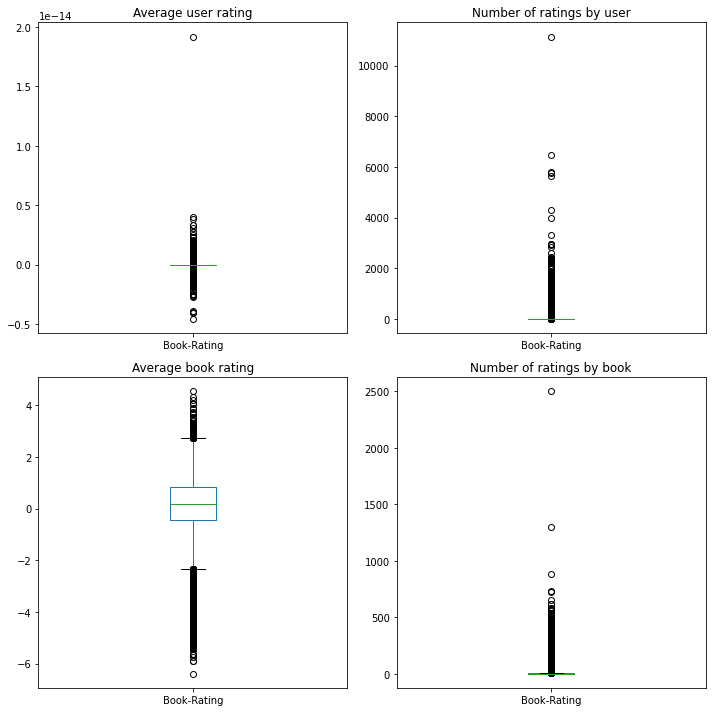

In [67]:
plot_groupby_stats(ratings)

# Saving preprocessed data

In [68]:
books.to_csv('data/preprocessed_books.csv', index=False)
users.to_csv('data/preprocessed_users.csv', index=False)
ratings.to_csv('data/preprocessed_ratings.csv', index=False)